<a href="https://colab.research.google.com/github/deniseiras/Forex_RNN/blob/main/Forex_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Rede RNN (LSTM) - Moeda

Denis M. A. Eiras
Atualizado: 30/08/2023

O notebook objetiva fazer a predição das moedas EURO e DÓLAR dos últimos 10 dias e comparar com os dados observados. Ainda, fazer a predição futura dos próximos 10 dias.

O dataset é disponibilizado através do uso da API yahoo finance.

Tempo aproximado de execução de xxx minutos

## Inicialização das bibliotecas e parâmetros gerais


In [ ]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import LSTM, Input, Dropout, Dense, RepeatVector, TimeDistributed, Conv1D, Flatten, MaxPooling1D, \
  BatchNormalization, Activation

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import pickle
#import glob
!pip install yfinance
import yfinance as yf
from IPython import display
import sys
import warnings
from time import time
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
print("")
print("Python version:")
print (sys.version)
print("\nTensorflow version:")
print(tf.__version__)
print('')



Python version:
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

Tensorflow version:
2.12.0



In [ ]:
eurobrl = "EURBRL=X"
usdbrl = "USDBRL=X"
msft = yf.Ticker( eurobrl)

# get stock info
print(msft.info)

# get historical market data
hist = msft.history(period="max")

# show actions (dividends, splits)
# print(msft.actions)

# show dividends
print(msft.dividends)

# show splits
print(msft.splits)

# show major holders
print(msft.major_holders)

# show institutional holders
print(msft.institutional_holders)


{'maxAge': 86400, 'priceHint': 4, 'previousClose': 5.3441, 'open': 5.3451, 'dayLow': 5.2806, 'dayHigh': 5.3469, 'regularMarketPreviousClose': 5.3441, 'regularMarketOpen': 5.3451, 'regularMarketDayLow': 5.2806, 'regularMarketDayHigh': 5.3469, 'volume': 0, 'regularMarketVolume': 0, 'averageVolume': 0, 'averageVolume10days': 0, 'averageDailyVolume10Day': 0, 'bid': 5.309, 'ask': 5.3115, 'bidSize': 0, 'askSize': 0, 'fiftyTwoWeekLow': 4.9557, 'fiftyTwoWeekHigh': 5.8212, 'fiftyDayAverage': 5.310156, 'twoHundredDayAverage': 5.451806, 'currency': 'BRL', 'exchange': 'CCY', 'quoteType': 'CURRENCY', 'symbol': 'EURBRL=X', 'underlyingSymbol': 'EURBRL=X', 'shortName': 'EUR/BRL', 'longName': 'EUR/BRL', 'firstTradeDateEpochUtc': 1070236800, 'timeZoneFullName': 'Europe/London', 'timeZoneShortName': 'BST', 'uuid': '0c2769c3-b02e-366e-b29c-5af701852cf7', 'messageBoardId': 'finmb_EURBRL_X', 'gmtOffSetMilliseconds': 3600000, 'trailingPegRatio': None}
Series([], Name: Dividends, dtype: float64)
Series([], Na

## Leitura e tratamento do Dataset



Requisição de dados para API *Yahoo Finance* e visualização de informações básicas.

---



[*********************100%%**********************]  2 of 2 completed
Data Inicial:  2003-12-01 00:00:00
Data Final  :  2023-08-31 00:00:00
Tamanho     :  4697



Text(0.5, 1.0, 'Preço de Encerramento')

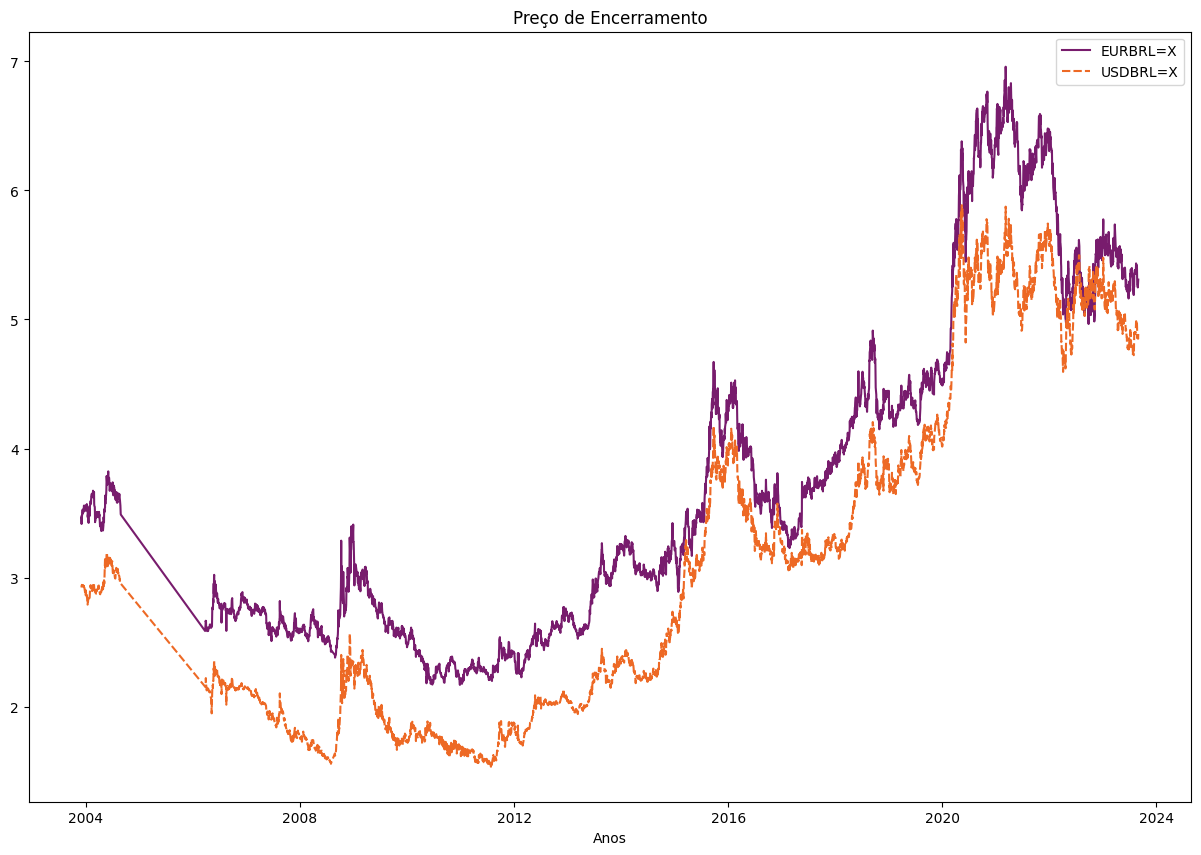

In [ ]:
arr_acoes = [eurobrl, usdbrl]

data = yf.download(arr_acoes)

df = data["Close"]
df.dropna(axis=0, inplace=True)
print("Data Inicial: ", df.index.min())
print("Data Final  : ", df.index.max())
print("Tamanho     : ", len(df))
print('')

fig, ax = plt.subplots(figsize=(15, 10), nrows=1, ncols=1)
sns.lineplot(data=df, palette='inferno', ax=ax,hue_order=arr_acoes)
ax.set_xlabel('Anos')
ax.set_title('Preço de Encerramento')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4697 entries, 2003-12-01 to 2023-08-31
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   EURBRL=X  4697 non-null   float64
 1   USDBRL=X  4697 non-null   float64
dtypes: float64(2)
memory usage: 110.1 KB


In [ ]:
df

,EURBRL=X,USDBRL=X
Date,,
2003-12-01,3.4621,2.9230
2003-12-02,3.4151,2.9310
2003-12-03,3.4799,2.9310
2003-12-04,3.4597,2.9430
2003-12-05,3.4794,2.9340
...,...,...
2023-08-25,5.2673,4.8803
2023-08-28,5.2485,4.8704
2023-08-29,5.2699,4.8726


In [ ]:
df.describe()

,EURBRL=X,USDBRL=X
count,4697.000000,4697.000000
mean,3.704247,3.098576
std,1.266701,1.281781
min,2.167800,1.533700
25%,2.632300,2.008400
50%,3.331700,2.907000
75%,4.424500,3.929200
max,6.959100,5.886400


Seleção e visualização do dataset de Treino e Teste.

---



Data Inicial Treino:  2003-12-01 00:00:00
Data Final   Treino:  2023-08-17 00:00:00
Tamanho      Treino:  4687

Data Inicial Teste:  2023-08-18 00:00:00
Data Final   Teste:  2023-08-31 00:00:00
Tamanho      Teste:  10


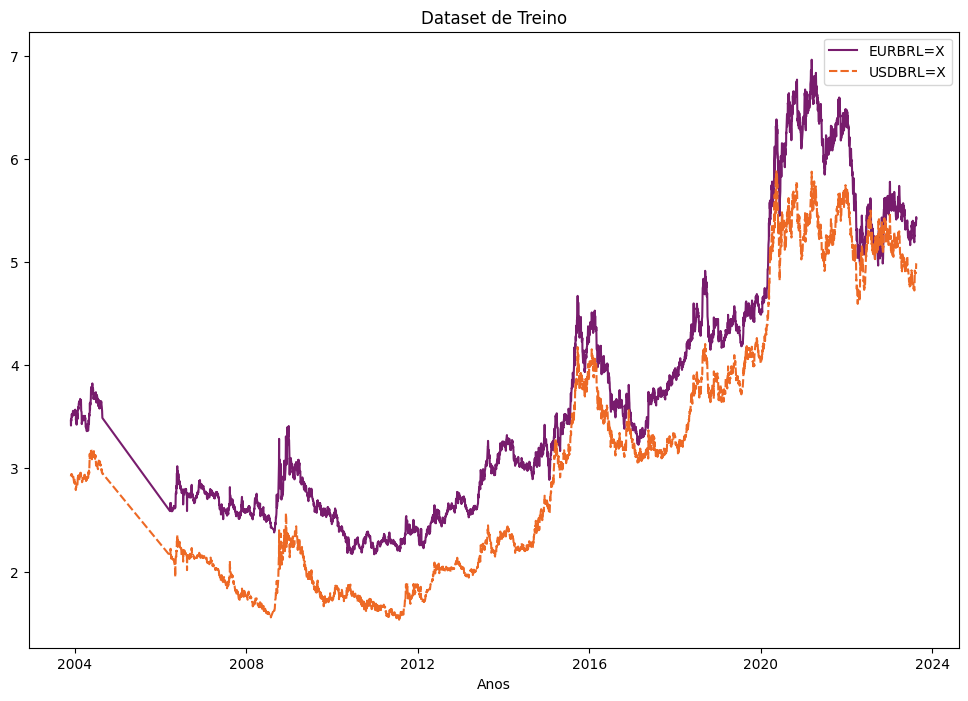

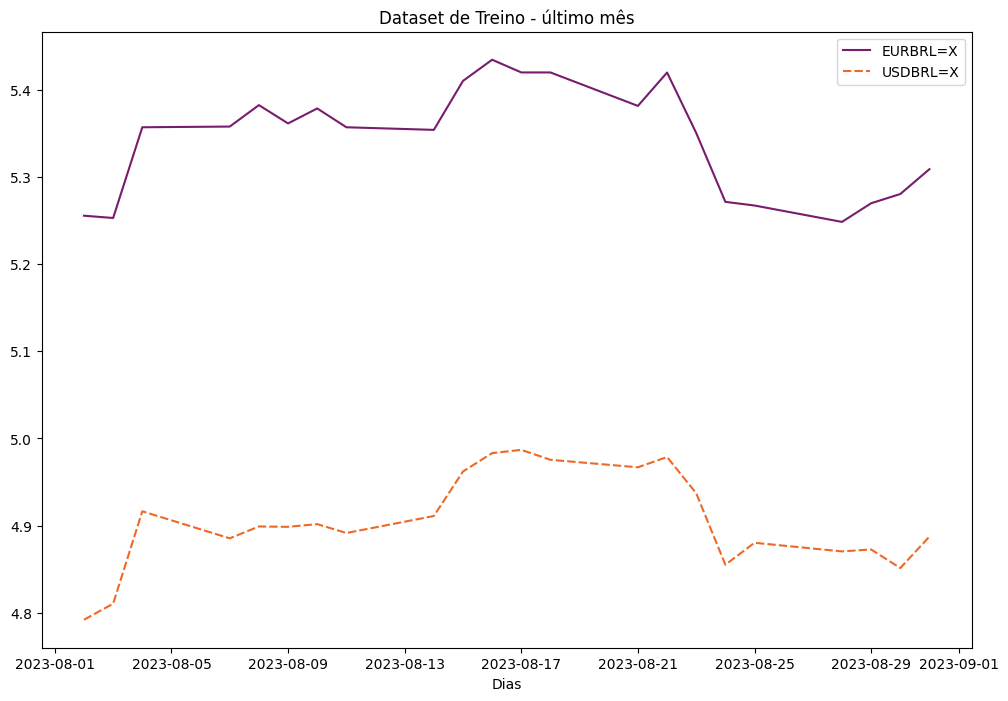

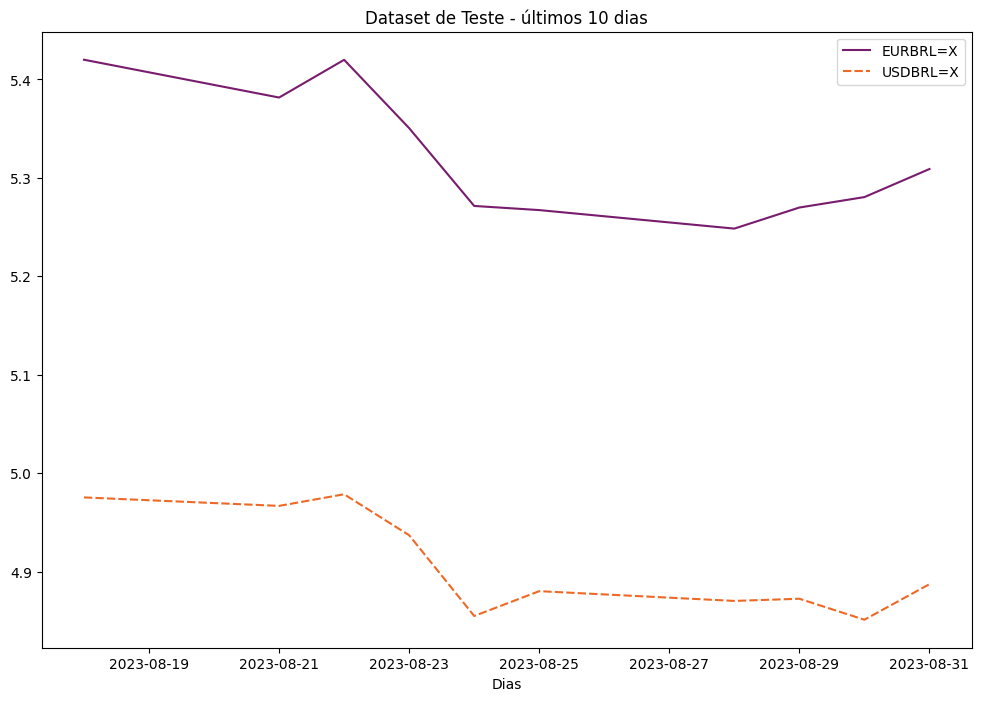

In [ ]:
today = datetime.today()

# prev últimos 10 dias
dias_teste = 10

data_corte_treino = today - timedelta(days=1)
while True:
  data_treino = df.loc[(df.index <= data_corte_treino)]
  data_teste = df.loc[(df.index > data_corte_treino)]
  if len(data_teste) == 10:
    break
  data_corte_treino = data_corte_treino - timedelta(days=1)


print("Data Inicial Treino: ", data_treino.index.min())
print("Data Final   Treino: ", data_treino.index.max())
print("Tamanho      Treino: ", len(data_treino))
print('')

print("Data Inicial Teste: ", data_teste.index.min())
print("Data Final   Teste: ", data_teste.index.max())
print("Tamanho      Teste: ", len(data_teste))

fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.lineplot(data=data_treino, palette="inferno", ax=ax, hue_order=arr_acoes)
ax.set_xlabel('Anos')
ax.set_title('Dataset de Treino')
# ax.set_ylim([0, 80])
plt.show()
print('')


# variáveis não usadas para treino, apenas visualização
tmp_data_corte_treino_30dias = today - timedelta(days=30)
tmp_data_treino_30dias = df.loc[(df.index >= tmp_data_corte_treino_30dias)]
fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.lineplot(data=tmp_data_treino_30dias, palette="inferno", ax=ax, hue_order=arr_acoes)
ax.set_xlabel('Dias')
ax.set_title('Dataset de Treino - último mês')
# ax.set_ylim([0, 80])
plt.show()
print('')

fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
sns.lineplot(data=data_teste, palette="inferno", ax=ax, hue_order=arr_acoes)
ax.set_xlabel('Dias')
ax.set_title(f'Dataset de Teste - últimos {dias_teste} dias')
plt.show()

## Pré Processamento

Função utilizada na transformação da base de dados em 3 dimensões, contendo:

1.   Uma sequência ou mais de exemplos (Batch Size);
2.   Um ponto ou mais de observações em série temporal (Time Steps);
3.   Numero de váriaveis contidas em cada Time Step (Features).

---



In [27]:
def preprocess(dataset, stock, TimeSteps, TesteLen):

    # StandardScaler
    n = len(dataset[[stock]])
    scaler = StandardScaler()
    scaler = scaler.fit(dataset[[stock]])

    df_scal = scaler.transform(dataset[[stock]])
    df_scal = df_scal.reshape(n, 1)

    X = df_scal
    X_samples = list()
    y_samples = list()

    NumerOfRows = len(X)
    for i in range(int(TimeSteps) , NumerOfRows , 1):
        x_sample = X[i-TimeSteps:i]
        y_sample = X[i]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    X_data=np.array(X_samples)
    X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)

    y_data=np.array(y_samples)
    y_data=y_data.reshape(y_data.shape[0], 1)

    # Separando dataset entre treino e teste
    if TesteLen > 0:
      X_train=X_data[:-TesteLen]
      X_test=X_data[-TesteLen:]
      y_train=y_data[:-TesteLen]
      y_test=y_data[-TesteLen:]
    else:
      X_train=X_data
      X_test=[]
      y_train=y_data
      y_test=[]
    return scaler, X_train, X_test, y_train, y_test


def preprocess_CNN1D(dataset, stock, TesteLen):
    # StandardScaler
    n = len(dataset[[stock]])
    scaler = StandardScaler()
    scaler = scaler.fit(dataset[[stock]])

    df_scal = scaler.transform(dataset[[stock]])
    df_scal = df_scal.reshape(n, 1)

    X = np.array(df_scal)
    # Separando dataset entre treino e teste
    if TesteLen > 0:
      X_train = X[:-TesteLen]
      X_test = X[-TesteLen:]
    else:
      X_train = X_train
      X_test = []

    y_train, y_test = X_train, X_test
    X_train = X_train.reshape(X_train.shape[0], 1, 1)
    X_test = X_test.reshape(X_test.shape[0], 1, 1)

    return scaler, X_train, X_test, y_train, y_test




Exemplo de transformação do dataset, utilizando 10 observações por batch, separando os ultimos len(data_teste) registros para avaliação dos melhores modelos.



In [ ]:
timesteps = 10
scaler, X_train, X_test, y_train, y_test = preprocess(df, eurobrl, timesteps, len(data_teste))
for inp, out in zip(X_train[0:3], y_train[0:3]):
    print(inp,'--', out)

# scaler, X_train, X_test, y_train, y_test = preprocess_CNN1D(df, eurobrl, len(data_teste))
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# for inp, out in zip(X_train[0:3], y_train[0:3]):
#     print(inp,'--', out)

## Construção dos modelos RNN

Para desenvolvimento do projeto foram testadas dois modelos de RNN, ambas submetidas ao mesmo dataset e a variação em paramêtros.

Modelo v1:
- 1 camada LSTM com ativação relu
- 1 camada Densa
- 1 camada de ativação linear

Modelo v2:
- 1 camada LSTM com ativação relu
- 1 camada Dropout 10%
- 1 camada LSTM com ativação relu e 1/4 do número de neurônios como input
- 1 camada Dropout 10%
- 1 camada Densa
- 1 camada de ativação linear

In [30]:
def train_model(mod, optimizer, X, y, batch_size, patience, epochs):

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=patience, mode='min')

  # only Adam implemented
  if optimizer == "Adam":
    adam = tf.keras.optimizers.Adam()
    mod.compile(loss=tf.losses.MeanSquaredError(),optimizer=adam, metrics=[tf.metrics.MeanAbsoluteError()])

  hist = mod.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[callback], verbose=0,
                  shuffle=False)

  loss_metric_train = mod.evaluate(X, y, verbose=0, batch_size=batch_size, use_multiprocessing=True)
  display.display( 'TRAINING set. Loss = {} , MAE = {}'.format(loss_metric_train[0], loss_metric_train[1]))

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(hist.history['loss'], label="Loss Treino")
  plt.plot(hist.history['val_loss'], label="Loss Validação")
  plt.plot(hist.history['mean_absolute_error'], label="MAE Treino")
  plt.ylim([0.0, 0.2])
  plt.xlim([0.0, epochs])
  plt.legend()
  plt.show()

  return mod, hist


def model_type(mod_type, unit, optimizer, timesteps, X, y, epochs=60, batch_size=32, patience=10):
  func = globals()[mod_type]
  return func(unit, optimizer, timesteps, X, y, epochs, batch_size, patience)


def model_v1(unit, optimizer, timesteps, X, y, epochs, batch_size, patience):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), return_sequences=False))
    mod.add(Dense(1))
    mod.add(Activation('linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist

def model_v2(unit, optimizer, timesteps, X, y, epochs, batch_size, patience):

    mod = Sequential()
    mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, 1), return_sequences=True))
    mod.add(Dropout(0.1))
    mod.add(LSTM(int(unit/4), activation='relu', return_sequences=False ))
    mod.add(Dropout(0.1))
    mod.add(Dense(1))
    mod.add(Activation('linear'))

    mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)

    return mod, hist

def model_v3(unit, optimizer, timesteps, X, y, epochs, batch_size, patience):

  mod = Sequential()
  mod.add(Conv1D(filters=unit, kernel_size=2, activation='relu', input_shape=(1,1)))
  # mod.add(BatchNormalization())
  mod.add(Activation("relu"))
  # mod.add(MaxPooling1D(pool_size=3))
  mod.add(Flatten())
  mod.add(Dense(unit, activation='linear'))

  mod, hist = train_model(mod, optimizer, X, y, batch_size, patience, epochs)
  return mod, hist

## Treinamento e Hiperparâmetrização

Parâmetros variados

1. Modelo: v1 ou v2
2. Numéro de Neurônios:  [64, 128]
3. Batch size: [16, 32, 64]


Treinando EURBRL=X com model_v1 , units=64, batch=16


'TRAINING set. Loss = 0.022576628252863884 , MAE = 0.12836812436580658'

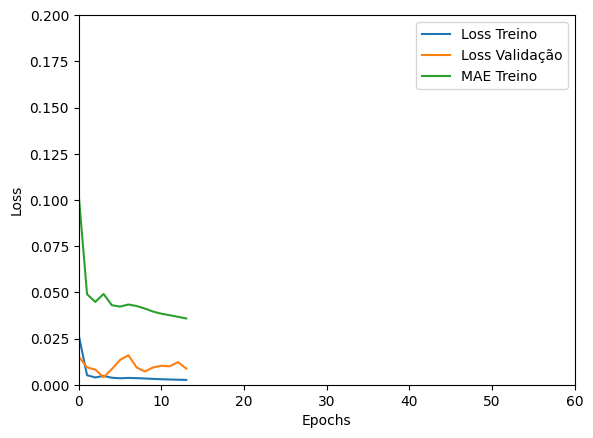

Tempo de treino: 0.7438690265019735 minutos
1/1 [==============================] - 0s 127ms/step
Treinando EURBRL=X com model_v1 , units=64, batch=32


'TRAINING set. Loss = 0.021883327513933182 , MAE = 0.11686402559280396'

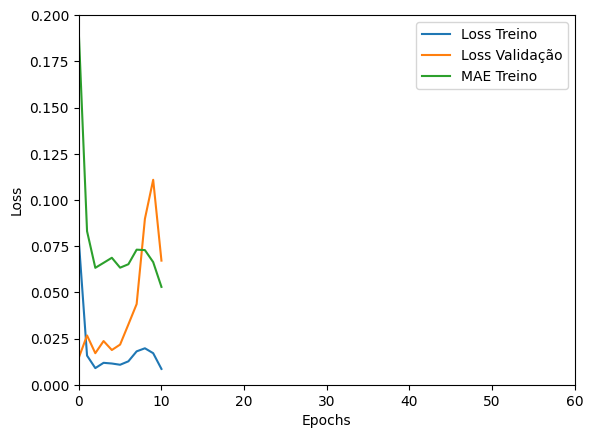

Tempo de treino: 0.16981439193089803 minutos
1/1 [==============================] - 0s 130ms/step
Treinando EURBRL=X com model_v1 , units=64, batch=64


'TRAINING set. Loss = 0.01105828769505024 , MAE = 0.0919990986585617'

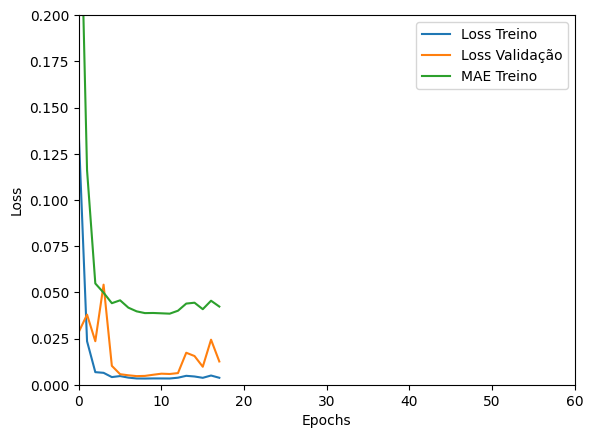

Tempo de treino: 0.19707897106806438 minutos
1/1 [==============================] - 0s 137ms/step
Treinando EURBRL=X com model_v1 , units=128, batch=16


'TRAINING set. Loss = 0.02377946861088276 , MAE = 0.13467887043952942'

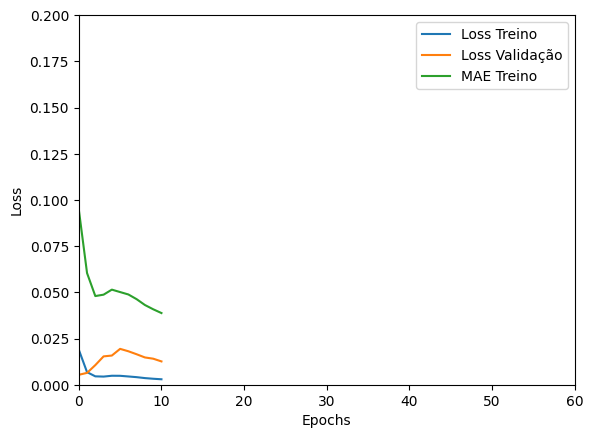

Tempo de treino: 0.4018155773480733 minutos
1/1 [==============================] - 0s 127ms/step
Treinando EURBRL=X com model_v1 , units=128, batch=32


'TRAINING set. Loss = 0.016812670975923538 , MAE = 0.10345473885536194'

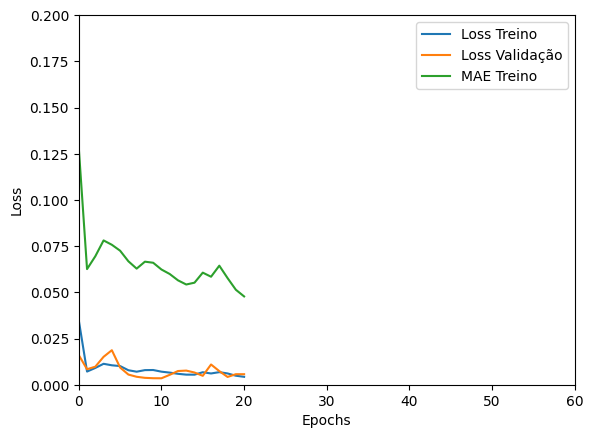

Tempo de treino: 0.719780433177948 minutos
1/1 [==============================] - 0s 208ms/step
Treinando EURBRL=X com model_v1 , units=128, batch=64


'TRAINING set. Loss = 0.00721200043335557 , MAE = 0.07119572162628174'

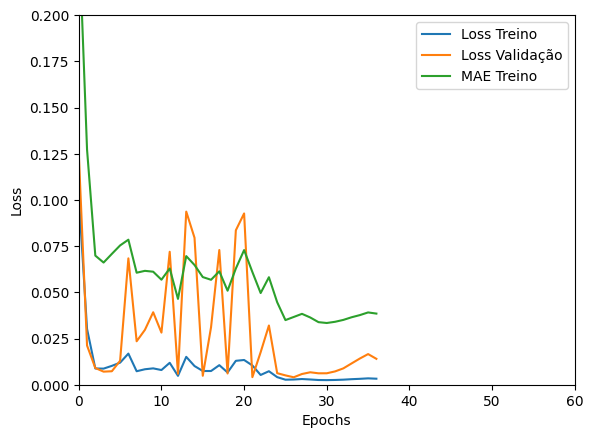

Tempo de treino: 0.6313050468762715 minutos
1/1 [==============================] - 0s 149ms/step
Treinando EURBRL=X com model_v2 , units=64, batch=16


'TRAINING set. Loss = 0.04408174008131027 , MAE = 0.1775815188884735'

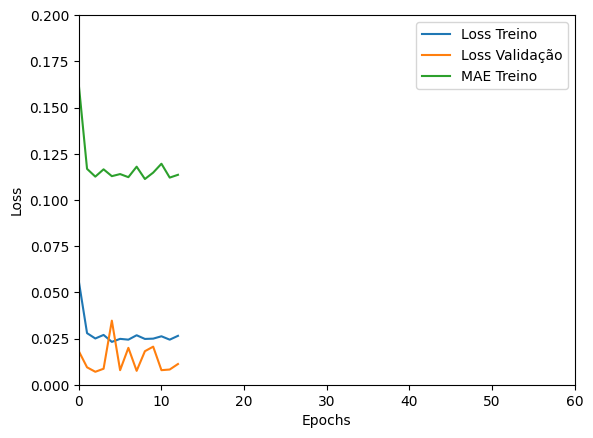

Tempo de treino: 0.7286557753880819 minutos
1/1 [==============================] - 1s 966ms/step
Treinando EURBRL=X com model_v2 , units=64, batch=32


'TRAINING set. Loss = 0.029825294390320778 , MAE = 0.13387161493301392'

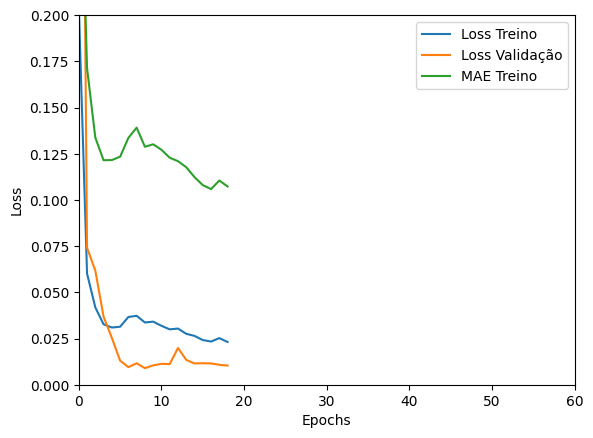

Tempo de treino: 0.4113934874534607 minutos
1/1 [==============================] - 0s 228ms/step
Treinando EURBRL=X com model_v2 , units=64, batch=64


'TRAINING set. Loss = 0.11825264990329742 , MAE = 0.28832030296325684'

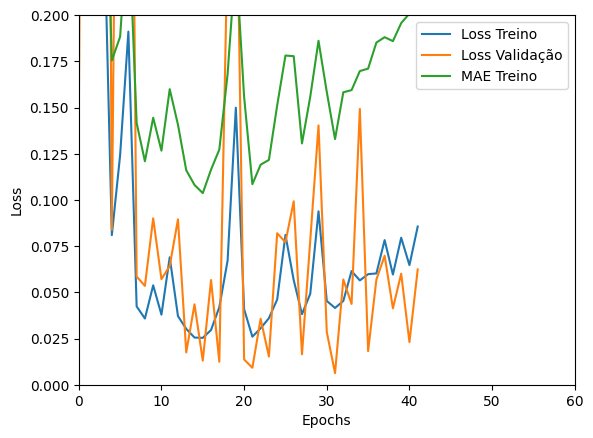

Tempo de treino: 0.7250819683074952 minutos
1/1 [==============================] - 0s 213ms/step
Treinando EURBRL=X com model_v2 , units=128, batch=16


'TRAINING set. Loss = 0.09510292112827301 , MAE = 0.24815607070922852'

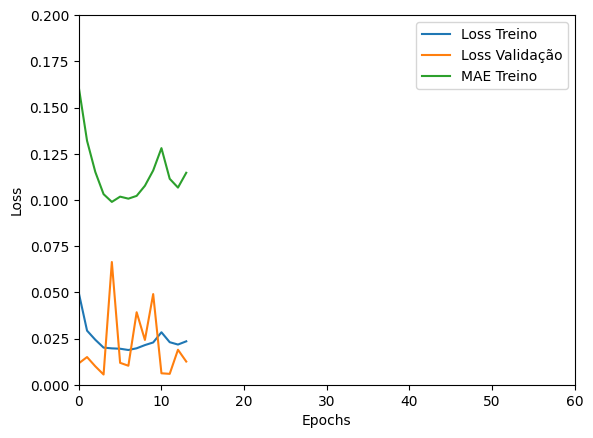

Tempo de treino: 0.7807175358136494 minutos
1/1 [==============================] - 0s 272ms/step
Treinando EURBRL=X com model_v2 , units=128, batch=32


'TRAINING set. Loss = 0.01883521117269993 , MAE = 0.1029408872127533'

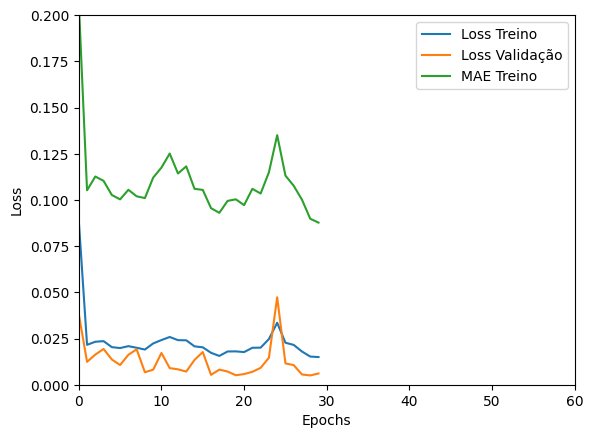

Tempo de treino: 1.1654292106628419 minutos
1/1 [==============================] - 0s 255ms/step
Treinando EURBRL=X com model_v2 , units=128, batch=64


'TRAINING set. Loss = 0.025179224088788033 , MAE = 0.12886300683021545'

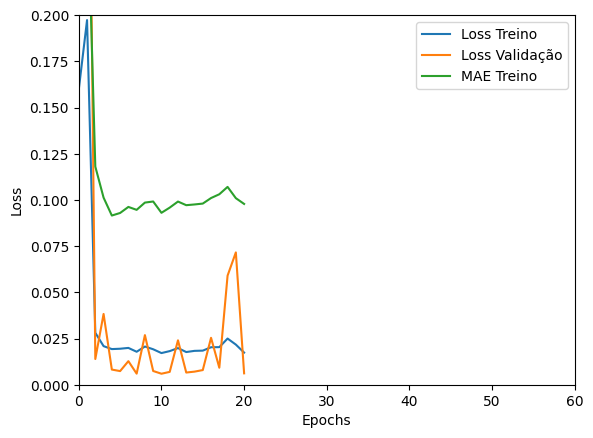

Tempo de treino: 0.5772951563199361 minutos
1/1 [==============================] - 0s 243ms/step
Treinando USDBRL=X com model_v1 , units=64, batch=16


'TRAINING set. Loss = 0.010467411018908024 , MAE = 0.08661486208438873'

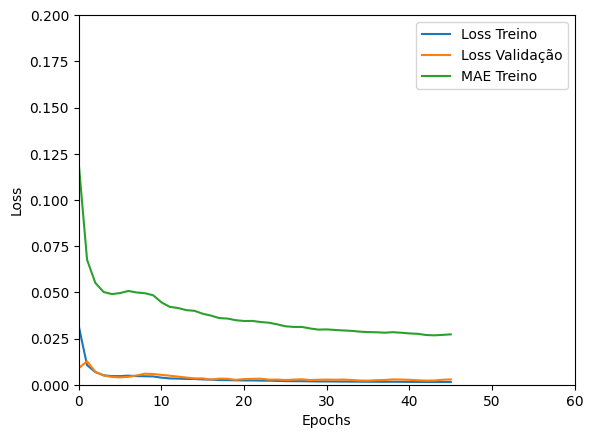

Tempo de treino: 1.4011912107467652 minutos
1/1 [==============================] - 0s 137ms/step
Treinando USDBRL=X com model_v1 , units=64, batch=32


'TRAINING set. Loss = 0.012706851586699486 , MAE = 0.08786727488040924'

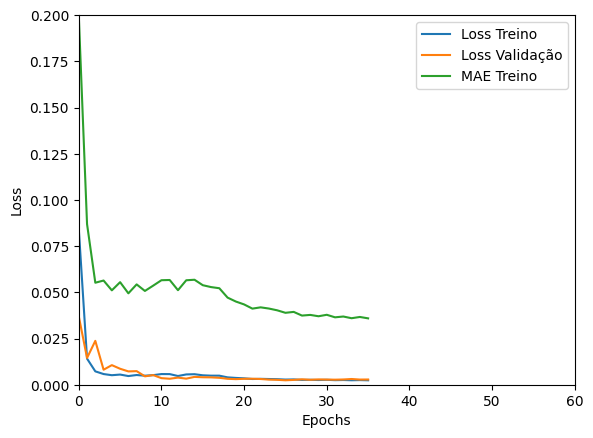

Tempo de treino: 0.44517239729563396 minutos
1/1 [==============================] - 0s 133ms/step
Treinando USDBRL=X com model_v1 , units=64, batch=64


'TRAINING set. Loss = 0.015665637329220772 , MAE = 0.10984570533037186'

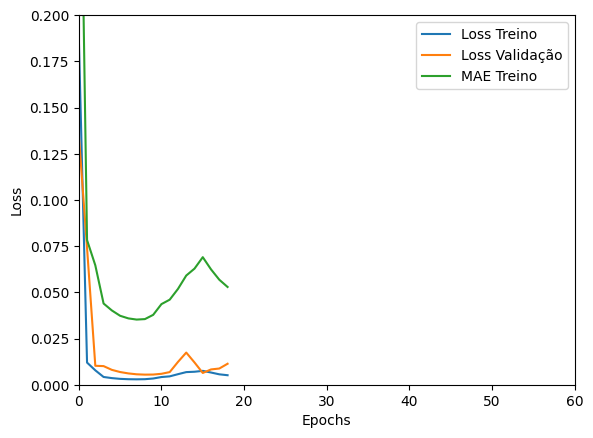

Tempo de treino: 0.16724658409754437 minutos
1/1 [==============================] - 0s 140ms/step
Treinando USDBRL=X com model_v1 , units=128, batch=16


'TRAINING set. Loss = 0.012693818658590317 , MAE = 0.09491731226444244'

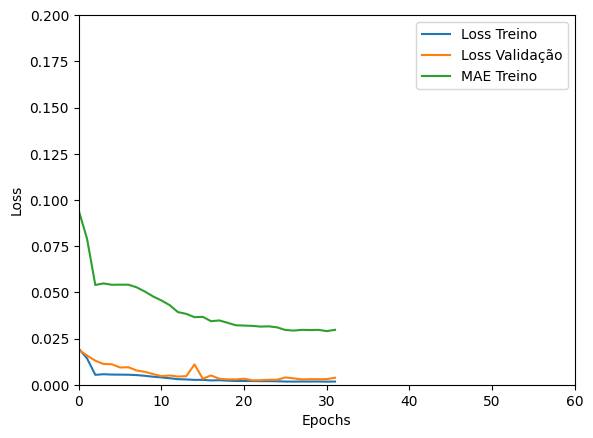

Tempo de treino: 1.4128388524055482 minutos
1/1 [==============================] - 0s 211ms/step
Treinando USDBRL=X com model_v1 , units=128, batch=32


'TRAINING set. Loss = 0.024269796907901764 , MAE = 0.12310677766799927'

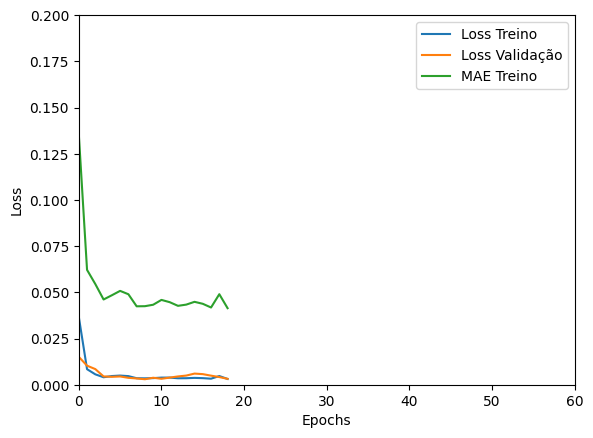

Tempo de treino: 0.7179318269093832 minutos
1/1 [==============================] - 0s 133ms/step
Treinando USDBRL=X com model_v1 , units=128, batch=64


'TRAINING set. Loss = 0.014658764936029911 , MAE = 0.10662566125392914'

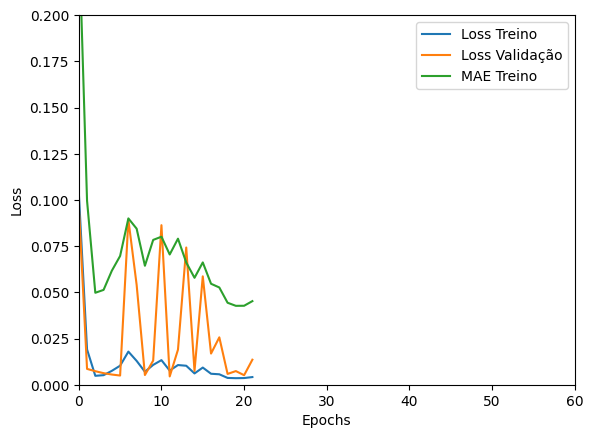

Tempo de treino: 0.7194202025731404 minutos
1/1 [==============================] - 0s 144ms/step
Treinando USDBRL=X com model_v2 , units=64, batch=16


'TRAINING set. Loss = 0.03412730619311333 , MAE = 0.15268577635288239'

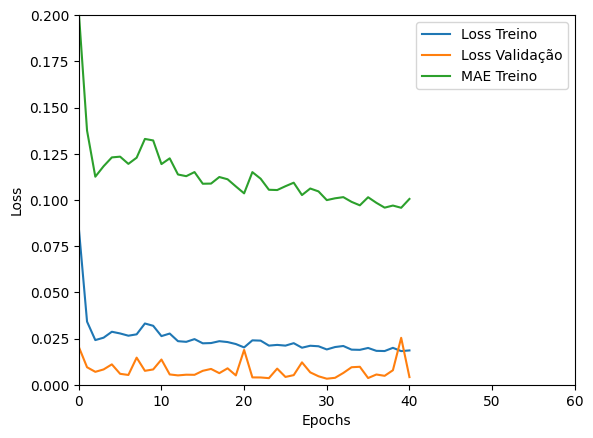

Tempo de treino: 2.419624880949656 minutos
1/1 [==============================] - 0s 259ms/step
Treinando USDBRL=X com model_v2 , units=64, batch=32


'TRAINING set. Loss = 0.03812327980995178 , MAE = 0.17400357127189636'

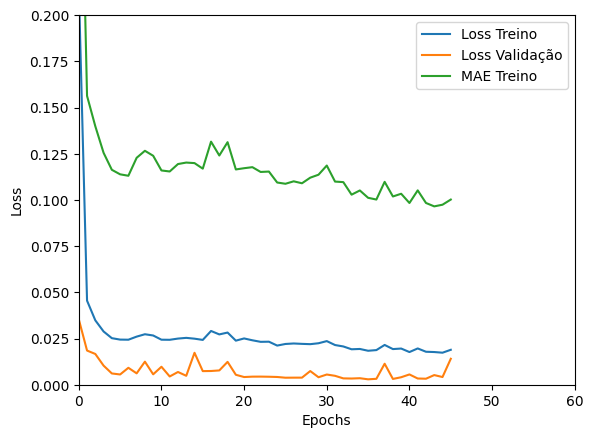

Tempo de treino: 1.4180121660232543 minutos
1/1 [==============================] - 0s 226ms/step
Treinando USDBRL=X com model_v2 , units=64, batch=64


'TRAINING set. Loss = 0.013303019106388092 , MAE = 0.09683970361948013'

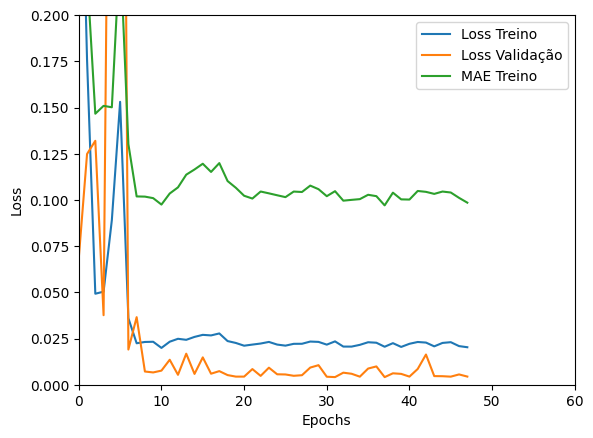

Tempo de treino: 0.7372372190157572 minutos
1/1 [==============================] - 0s 242ms/step
Treinando USDBRL=X com model_v2 , units=128, batch=16


'TRAINING set. Loss = 0.07225894182920456 , MAE = 0.21848566830158234'

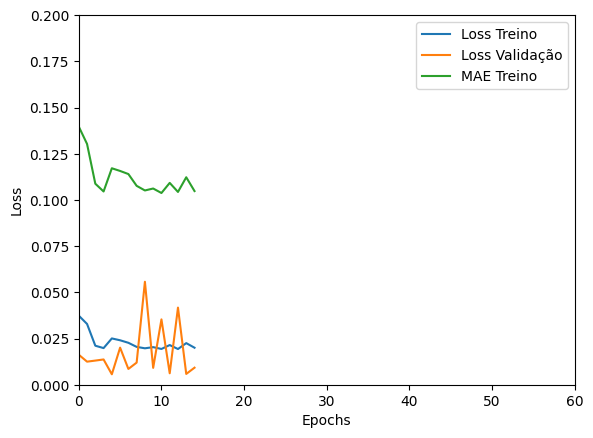

Tempo de treino: 1.4234490036964416 minutos
1/1 [==============================] - 0s 248ms/step
Treinando USDBRL=X com model_v2 , units=128, batch=32


'TRAINING set. Loss = 0.010322153568267822 , MAE = 0.0886528342962265'

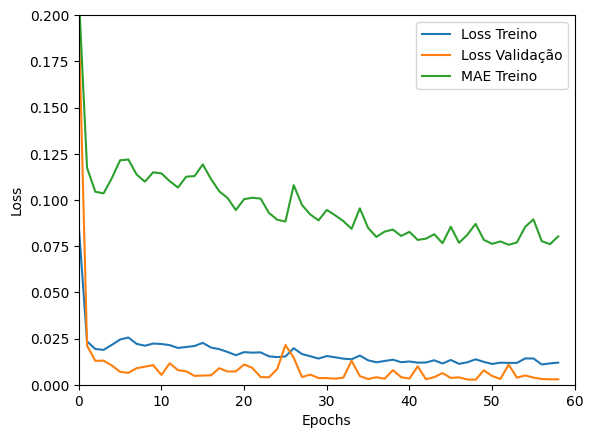

Tempo de treino: 2.418135134379069 minutos
1/1 [==============================] - 0s 251ms/step
Treinando USDBRL=X com model_v2 , units=128, batch=64


'TRAINING set. Loss = 0.03383462503552437 , MAE = 0.1539739966392517'

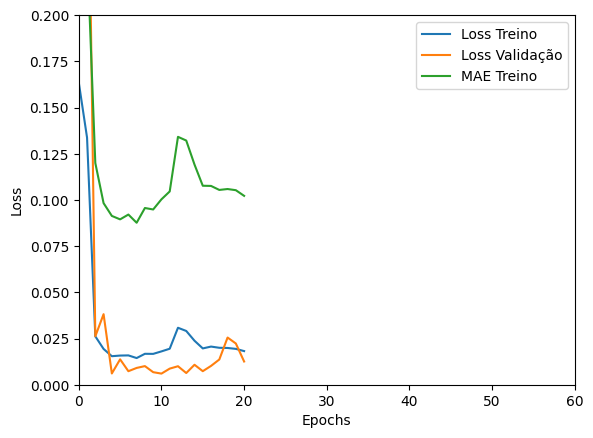

Tempo de treino: 0.7329586664835612 minutos
1/1 [==============================] - 0s 229ms/step


In [34]:
all_results = pd.DataFrame(columns=["model_type","model","stock","unit","optimizer", "batch_size", "loss","mae"])

TotalFeatures = 1
epochs = 60
i = 1
times_exec = 1

result_all_best = None
# result_all_best = pd.DataFrame(columns=["model_type", "stock","unit","optimizer", "batch_size", "loss","mae"])
# result_all_best = result_all_best.append({'model_type':'model_v1', 'stock':eurobrl, 'unit': 128, 'optimizer': 'Adam', 'batch_size': 64, 'loss': 0.001344, 'mae': 0.031031}, ignore_index=True)
# result_all_best = result_all_best.append({'model_type':'model_v2', 'stock':usdbrl,  'unit': 128, 'optimizer': 'Adam', 'batch_size': 32, 'loss': 0.000670, 'mae': 0.021304}, ignore_index=True)


if result_all_best is not None:

  pass
  # for index, item in result_all_best.iterrows():
  #   scaler, X_train, X_test, y_train, y_test = preprocess(df, item['stock'], timesteps, len(data_teste))
  #   inittime = time()
  #   m, h = model_type(item['model_type'], unit=item['unit'], optimizer=item['optimizer'], timesteps=timesteps, X=X_train, y=y_train, epochs=epochs, batch_size=item['batch_size'])
  #   endtime = time()
  #   print(f'Tempo de treino: {(endtime-inittime)/60} minutos' )
  #   y_pred = m.predict(X_test)
  #   score = m.evaluate(X_test, y_test, batch_size=32, verbose=0)
  #   all_results = all_results.append({'model_type': item['model_type'], 'model':m, 'stock':item['stock'],'unit':item['unit'], \
  #     'optimizer':item['optimizer'], "batch_size":item['batch_size'], "loss":score[0], "mae":score[1]}, ignore_index=True)

else:

  for times in range(times_exec):
    for stock in arr_acoes:
      for model_type_str in ['model_v1', 'model_v2']:
        if model_type_str in ['model_v1', 'model_v2']:
          scaler, X_train, X_test, y_train, y_test = preprocess(df, stock, timesteps, len(data_teste))
        else:
          scaler, X_train, X_test, y_train, y_test = preprocess_CNN1D(df, stock, len(data_teste))
        for optimizer in ['Adam']:
          for unit in [64, 128]:
            for batch_size in [16, 32, 64]:
              inittime = time()
              print(f"Treinando {stock} com {model_type_str} , units={unit}, batch={batch_size}")
              m, h = model_type(model_type_str, unit=unit, optimizer=optimizer, timesteps=timesteps, X=X_train, y=y_train, epochs=epochs, batch_size=batch_size)
              endtime = time()
              print(f'Tempo de treino: {(endtime-inittime)/60} minutos' )
              y_pred = m.predict(X_test)
              score = m.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
              all_results = all_results.append({'model_type': model_type_str, 'model':m, 'stock':stock,'unit':unit, 'optimizer':optimizer,
                                            "loss":score[0], "mae":score[1], "batch_size":batch_size}, ignore_index=True)

## Avaliação na base de testes
Desempenho ordenado por moeda e menor MAE na base de testes

In [35]:
all_results.sort_values(by=['stock','mae'])

,model_type,model,stock,unit,optimizer,batch_size,loss,mae
7,model_v2,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,32,0.002182,0.039670
11,model_v2,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,64,0.002399,0.042190
10,model_v2,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,32,0.005570,0.063058
4,model_v1,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,32,0.007012,0.075573
6,model_v2,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,16,0.010531,0.093846
0,model_v1,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,16,0.010524,0.096452
9,model_v2,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,16,0.012091,0.100391
2,model_v1,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,64,0.015792,0.120129
3,model_v1,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,16,0.015656,0.120245
5,model_v1,<keras.engine.sequential.Sequential object at ...,EURBRL=X,128,Adam,64,0.017442,0.126734


Salvando melhores modelos encontrados

In [36]:
result_all_best_arr = []
for stock in arr_acoes:
  best = all_results[all_results["stock"] == f"{stock}"].sort_values("mae", ascending=True).head(1)
  result_all_best_arr.append(best)
  mod = best["model"]
  mod = mod.iloc[0]
  mod.save(f"mod_{stock}")

result_all_best = pd.concat(result_all_best_arr)
result_all_best

,model_type,model,stock,unit,optimizer,batch_size,loss,mae
7,model_v2,<keras.engine.sequential.Sequential object at ...,EURBRL=X,64,Adam,32,0.002182,0.039670
22,model_v2,<keras.engine.sequential.Sequential object at ...,USDBRL=X,128,Adam,32,0.000953,0.021711


### Boxplot

Construção dos dados de predição, também usados no Boxplot e Swarmplot

---

In [37]:
aval = pd.DataFrame()

for index, setup in result_all_best.iterrows():

  scaler, X_train, X_test, y_train, y_test = preprocess(df, setup["stock"], timesteps, len(data_teste))

  mod = tf.keras.models.load_model(f'mod_{setup["stock"]}')
  y_pred = mod.predict(X_test)
  y_pred = scaler.inverse_transform(y_pred)
  y_real = scaler.inverse_transform(y_test)

  aval[f'{setup["stock"]}'] = y_pred[:,0]
  aval[f'{setup["stock"]}_Real'] = y_real[:,0]



1/1 [==============================] - 0s 236ms/step


Figura com boxplot e swarmplot para os melhores modelos

---

Text(0.5, 1.0, 'Performance Boxplot')

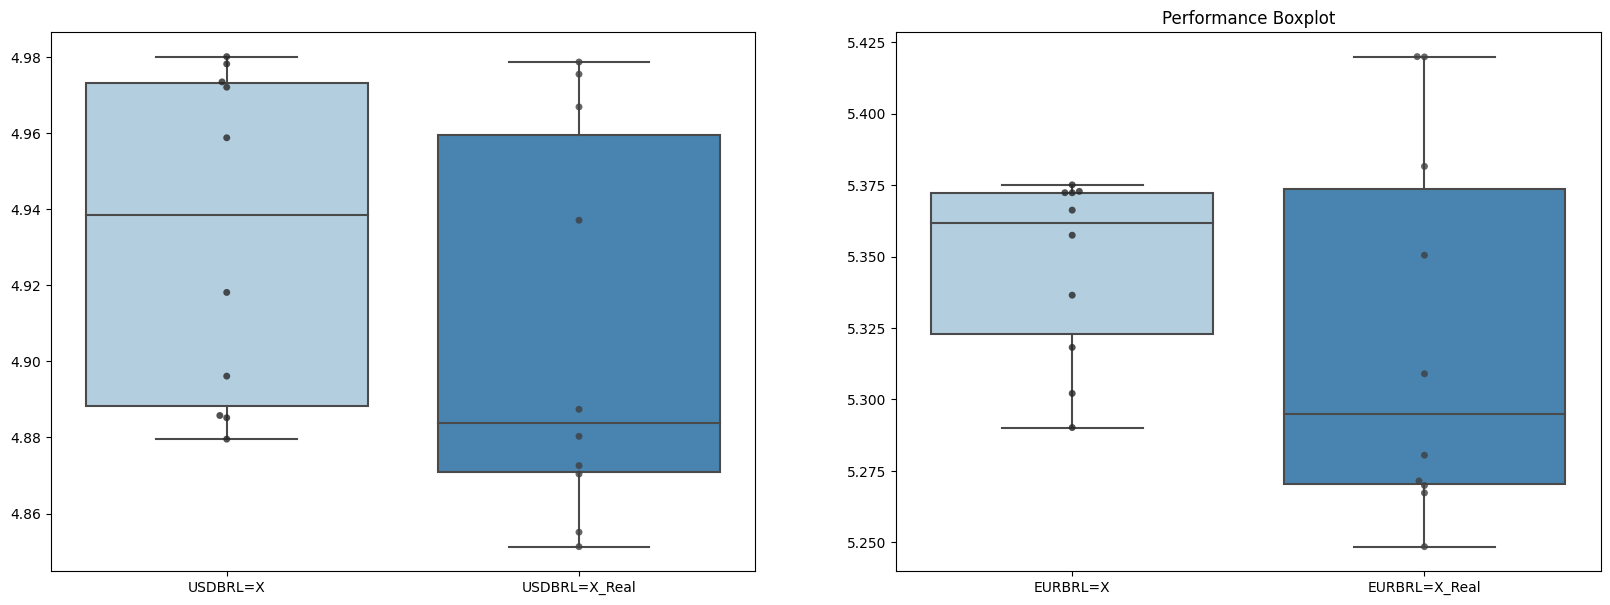

In [38]:
fig, ax = plt.subplots(figsize=(20, 7), nrows=1, ncols=2)
sns.boxplot(data=aval.filter(regex=usdbrl), dodge=False, palette="Blues", ax=ax[0])
sns.swarmplot(data=aval.filter(regex=usdbrl), color=".25", alpha=0.8, ax=ax[0])

sns.boxplot(data=aval.filter(regex=eurobrl), dodge=False, palette="Blues", ax=ax[1])
sns.swarmplot(data=aval.filter(regex=eurobrl), color=".25", alpha=0.8, ax=ax[1])

ax[1].set_title("Performance Boxplot")

### Performance

Figura predição por moeda

In [39]:
def plot_aval(aval):
  fig, ax = plt.subplots(figsize=(30, 12), nrows=1, ncols=2)

  sns.lineplot(data=aval.filter(regex=usdbrl), palette="inferno", ax=ax[0], hue_order=[f'{usdbrl}_Real' ,usdbrl])
  ax[0].set_xlabel('Dias')
  ax[0].set_title(usdbrl)

  sns.lineplot(data=aval.filter(regex=eurobrl), palette="inferno", ax=ax[1], hue_order=[f'{eurobrl}_Real', eurobrl])
  ax[1].set_xlabel('Dias')
  ax[1].set_title(eurobrl)

   EURBRL=X  EURBRL=X_Real  USDBRL=X  USDBRL=X_Real
0  5.366275         5.4200  4.978200         4.9755
1  5.372387         5.3816  4.980117         4.9669
2  5.372849         5.4199  4.973482         4.9787
3  5.375123         5.3505  4.972085         4.9371
4  5.372349         5.2715  4.958788         4.8551
5  5.357494         5.2673  4.918131         4.8803
6  5.336506         5.2485  4.896123         4.8704
7  5.318231         5.2699  4.885775         4.8726
8  5.302127         5.2805  4.885181         4.8513
9  5.290177         5.3090  4.879567         4.8874


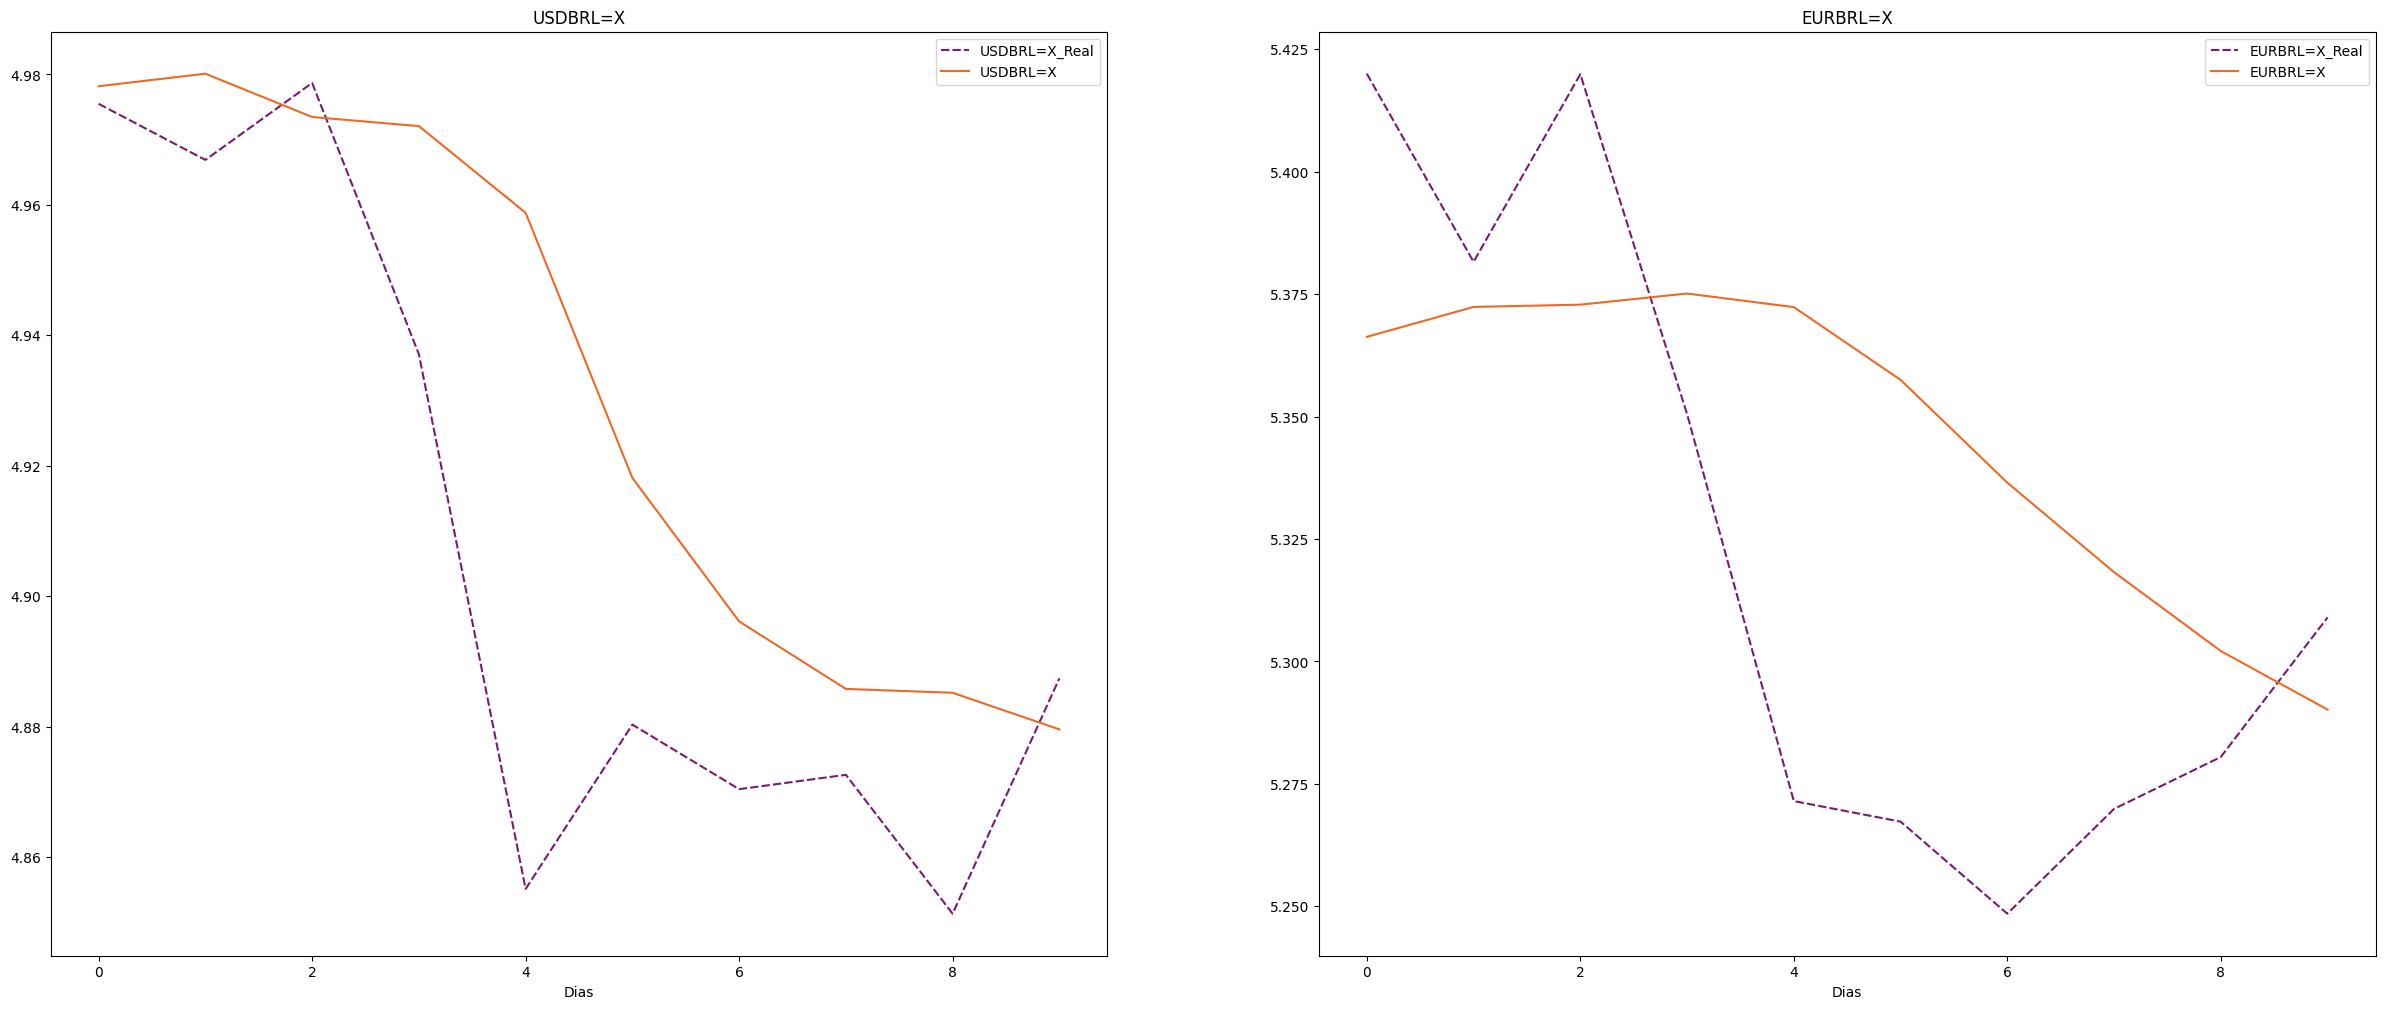

In [40]:
plot_aval(aval)
print(aval)


## Avaliação no futuro


### Treinamento com dataset completo

**TODO - create loop to prediction**

e Construção dos dados de predição, também usados no Boxplot e Swarmplot

In [ ]:
aval_fut = aval.copy()

for index, setup in result_all_best.iterrows():

  scaler, X_train, X_test, y_train, y_test = preprocess(df, setup['stock'], timesteps, 0)
  inittime = time()
  print(f"Treinando {setup['stock']} com {setup['model_type']} , units={setup['unit']}, batch={setup['batch_size']}")
  m, h = model_type(setup['model_type'], unit=setup['unit'], optimizer=setup['optimizer'], timesteps=timesteps,
                    X=X_train, y=y_train, epochs=epochs, batch_size=setup['batch_size'])
  endtime = time()
  print(f'Tempo de treino: {(endtime-inittime)/60} minutos' )

  # predicting for the last
  y_pred = m.predict(X_train[-1:,:])
  y_pred = scaler.inverse_transform(y_pred)
  aval_fut[f'{setup["stock"]}'] = y_pred[:,0]


  break

### Boxplot

Figura com boxplot e swarmplot para os melhores modelos

---

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7), nrows=1, ncols=2)
# sns.boxplot(data=aval_fut.filter(regex=usdbrl), dodge=False, palette="Blues", ax=ax[0])
# sns.swarmplot(data=aval_fut.filter(regex=usdbrl), color=".25", alpha=0.8, ax=ax[0])

sns.boxplot(data=aval_fut.filter(regex=eurobrl), dodge=False, palette="Blues", ax=ax[1])
sns.swarmplot(data=aval_fut.filter(regex=eurobrl), color=".25", alpha=0.8, ax=ax[1])

ax[1].set_title("Performance Boxplot")

### Performance

Figura predição por moeda

In [ ]:
def plot_aval(aval):
  fig, ax = plt.subplots(figsize=(30, 12), nrows=1, ncols=2)

  # sns.lineplot(data=aval.filter(regex=usdbrl), palette="inferno", ax=ax[0], hue_order=[f'{usdbrl}_Real' ,usdbrl])
  # ax[0].set_xlabel('Dias')
  # ax[0].set_title(usdbrl)

  sns.lineplot(data=aval_fut.filter(regex=eurobrl), palette="inferno", ax=ax[1], hue_order=[f'{eurobrl}_Real', eurobrl])
  ax[1].set_xlabel('Dias')
  ax[1].set_title(eurobrl)

In [ ]:
plot_aval(aval_fut)
print(aval_fut)
